# Projet 5: Segmentez les clients d'un site e-commerce (mise à jour)

## Table des matières: <a class="anchor" id="0"></a>

1. [Import des librairies et configurations générales](#library)
2. [Chargement et visualisation des données](#data)
3. [Contrat de maintenance](#maint)

## Import des librairies et configurations générales <a class="anchor" id="library"></a>

In [1]:
# Pour vérifier si la convention PEP8 est respectée
%load_ext pycodestyle_magic
%pycodestyle_on

In [2]:
# import warnings
# warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import datetime as dt

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import adjusted_rand_score


# Configuration générale des graphiques
parameters = {'axes.labelsize': 13,
              'axes.titlesize': 16,
              'axes.titleweight': 'bold'}
plt.rcParams.update(parameters)

# Modification de l'affichage des lignes et colonnes pour plus de lisibilité
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', None)
# pd.options.display.float_format = '{:20,.2f}'.format

## Chargement et visualisation des données <a class="anchor" id="data"></a>

In [3]:
# Import de la table des données par customer_unique_id
df_customers = pd.read_csv('data/df_customers.csv')

# Import de la table des données par order_id
df_conso = pd.read_csv('data/df_conso.csv')

In [4]:
df_customers

,Unnamed: 0,customer_unique_id,cat_pref,big_cat_pref,date_dern_com,moy_paiement_pref,Frequency,note_moy_com,facil_paiement_max_moy_com,nb_art_moy_com,nb_art_tot_ach,nb_art_diff_ach,Monetary,montant_moy_com,prix_trans_moy_com,prix_moy_art_com,prix_max_art,prix_min_art,jrs_livr_moy_com,respect_date_livr_moy_com,jrs_redac_review_moy_com,dist_cli_vend_moy_km,customer_zone,order_purchase_timestamp,Recency
0,0,0000366f3b9a7992bf8c76cfdf3221e2,bed_bath_table,house/decoration/furnitures,2018-05-10 10:56:27,credit_card,1,5.0,8.0,1.0,1.0,1.0,129.90,129.90,12.00,129.90,129.90,129.90,6.0,4.0,4.0,110.459074,Sud_Est,2018-05-10 10:56:27,113
1,1,0000b849f77a49e4a4ce2b2a4ca5be3f,health_beauty,hygiene/beauty,2018-05-07 11:11:27,credit_card,1,4.0,1.0,1.0,1.0,1.0,18.90,18.90,8.29,18.90,18.90,18.90,3.0,4.0,0.0,22.219469,Sud_Est,2018-05-07 11:11:27,116
2,2,0000f46a3911fa3c0805444483337064,stationery,house/decoration/furnitures,2017-03-10 21:05:03,credit_card,1,3.0,8.0,1.0,1.0,1.0,69.00,69.00,17.22,69.00,69.00,69.00,25.0,1.0,1.0,516.692345,Sud,2017-03-10 21:05:03,539
3,3,0000f6ccb0745a6a4b88665a16c9f078,telephony,electronics,2017-10-12 20:29:41,credit_card,1,4.0,4.0,1.0,1.0,1.0,25.99,25.99,17.63,25.99,25.99,25.99,20.0,11.0,1.0,2479.683397,Nord,2017-10-12 20:29:41,323
4,4,0004aac84e0df4da2b147fca70cf8255,telephony,electronics,2017-11-14 19:45:42,credit_card,1,5.0,6.0,1.0,1.0,1.0,180.00,180.00,16.89,180.00,180.00,180.00,13.0,7.0,4.0,154.421184,Sud_Est,2017-11-14 19:45:42,290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90999,90999,fffcf5a5ff07b0908bd4e2dbc735a684,health_beauty,hygiene/beauty,2017-06-08 21:00:36,credit_card,1,5.0,10.0,2.0,2.0,2.0,1570.00,1570.00,497.42,1570.00,890.00,680.00,27.0,26.0,4.0,1995.211147,Nord_Est,2017-06-08 21:00:36,449
91000,91000,fffea47cd6d3cc0a88bd621562a9d061,baby,baby,2017-12-10 20:07:56,credit_card,1,4.0,1.0,1.0,1.0,1.0,64.89,64.89,19.69,64.89,64.89,64.89,30.0,2.0,5.0,1526.190752,Centre_Est,2017-12-10 20:07:56,264
91001,91001,ffff371b4d645b6ecea244b27531430a,auto,auto,2017-02-07 15:49:16,credit_card,1,5.0,1.0,1.0,1.0,1.0,89.90,89.90,22.56,89.90,89.90,89.90,14.0,29.0,2.0,1525.156719,Centre,2017-02-07 15:49:16,570
91002,91002,ffff5962728ec6157033ef9805bacc48,watches_gifts,electronics,2018-05-02 15:17:41,credit_card,1,5.0,5.0,1.0,1.0,1.0,115.00,115.00,18.69,115.00,115.00,115.00,11.0,13.0,2.0,637.415856,Sud_Est,2018-05-02 15:17:41,121


In [5]:
# Sélection des données
df_clust = df_customers.set_index(['customer_unique_id'])[
    ['Recency', 'Frequency', 'Monetary', 'note_moy_com',
     'jrs_livr_moy_com', 'nb_art_moy_com']]

In [6]:
df_clust.head()

,Recency,Frequency,Monetary,note_moy_com,jrs_livr_moy_com,nb_art_moy_com
customer_unique_id,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,113,1,129.90,5.0,6.0,1.0
0000b849f77a49e4a4ce2b2a4ca5be3f,116,1,18.90,4.0,3.0,1.0
0000f46a3911fa3c0805444483337064,539,1,69.00,3.0,25.0,1.0
0000f6ccb0745a6a4b88665a16c9f078,323,1,25.99,4.0,20.0,1.0
0004aac84e0df4da2b147fca70cf8255,290,1,180.00,5.0,13.0,1.0


## Contrat de maintenance <a class="anchor" id="maint"></a>

Notre modèle de segmentation choisi, il nous reste à faire une recommandation de fréquence à laquelle cette segmentation doit être mise à jour pour rester pertinente. Elle nous permettra d'établir un contrat de maintenance.

Pour ce faire, nous allons nous baser sur l'Adjusted Rand Index (ARI) qui est l'une des métriques les plus utilisées pour valider les performances de clustering.

L'ARI calcule une mesure de similarité entre deux clusters en considérant toutes les paires d'échantillons et en comptant les paires qui sont assignées dans les mêmes ou différents clusters dans les clusters prédits et réels.

L'ARI doit être interprété comme suit : 
- ARI >= 0,90 excellente récupération
- 0,80 =< ARI < 0,90 bonne récupération
- 0,65 =< ARI < 0,80 récupération modérée
- ARI < 0,65 mauvaise récupération

Dans un premier temps, nous allons recalculer l'indicateur "Recency" en prenant la dernière date de commande de la base. Nous allons ensuite créer une fonction nous permettant de partir de notre base clients entière et de retrancher un nombre de jours de commandes que nous pourrons choisir. Ensuite, nous créérons une autre fonction qui nous permettra de recalculer les indicateurs RFM de notre nouvelle base.

- Nous entrainerons notre modèle K-means sur la base entière en standardisant nos variables
- De manière itérative, nous retrancherons 2 semaines de commandes à chaque fois et recalculerons nos indicateurs RFM
- Nous entrainerons notre modèle sur cette nouvelle base après avoir standardisé les données et nous récupèrerons les clusters
- Nous prédirons les clusters de cette nouvelle base à partir de notre modèle initial
- Nous calculerons l'Adjusted Rand Index (ARI) en comparant les clusters attribués aux données avant et après réentrainement du modèle
- Lorsque l'ARI sera < 0.8, la segmentation devra être mise à jour et le modèle réentrainé

In [7]:
# Recalcul du Recency en prenant la dernière date de commande de la base
now = dt.datetime(year=2018, month=8, day=29, hour=15, minute=0, second=37)
df_conso['diff_days'] = (now - pd.to_datetime(df_conso[
    'order_purchase_timestamp'])).dt.days

In [8]:
# Fonction qui permet de créer les bases en enlevant une période
def create_new_base(df, days):
    df_new = df.loc[df['diff_days'] > days]
    return df_new

In [9]:
# Fonction qui recalcule les indicateurs RFM suivant la nouvelle période
def calc_RFM(df):
    df_customers_new = df.copy()

    df_customers_gb = df_customers_new.groupby(['customer_unique_id'],
                                               as_index=False,
                                               dropna=False).agg(
        date_dern_com=('order_purchase_timestamp', 'max'),
        Frequency=('order_id', 'nunique'),
        Monetary=('prix_tot_art', 'sum'),
        note_moy_com=('review_score', 'mean'),
        jrs_livr_moy_com=('dur_livr_jrs', 'mean'),
        nb_art_moy_com=('nb_art', 'mean'))

    now = pd.to_datetime(df_customers_gb['date_dern_com']).max()
    df_customers_gb['date_dern_com'] = pd.to_datetime(
        df_customers_gb['date_dern_com'])
    df_customers_gb['Recency'] = (now - df_customers_gb[
        'date_dern_com']).dt.days
    df_customers_drop = df_customers_gb.drop(columns='date_dern_com')

    df_customers = df_customers_drop.set_index('customer_unique_id')

    return df_customers

In [10]:
# Entrainement du modèle sur toute la base
RFM0 = calc_RFM(df_conso)
RFM0_std = StandardScaler().fit_transform(RFM0)
M0 = KMeans(n_clusters=6, init='k-means++', random_state=42).fit(RFM0_std)

In [11]:
# Recalcul de la nouvelle base en retranchant 14 jours de commandes
B1 = create_new_base(df_conso, days=14)

In [12]:
# Recalcul des indicateurs de la nouvelle base
RFM1 = calc_RFM(B1)

In [13]:
# Calcul du modèle 1 et récupération des clusters
RFM1_std = StandardScaler().fit_transform(RFM1)
M1 = KMeans(n_clusters=6, init='k-means++', random_state=42).fit(RFM1_std)
C1 = M1.labels_

In [14]:
# Clusters du Modèle 0 pour la base 1
C1_M0 = M0.predict(RFM1_std)

In [15]:
# Calcul de l'ARI
ARI = adjusted_rand_score(C1, C1_M0)
ARI

0.9866910778470577

Nous allons automatiser au maximum la fonction et procéder de manière itérative jusqu'à avoir retranché toutes les commandes:
- à partir de la base initiale avec toutes les commandes
- suppression de x jours de commandes les plus récentes
- recalcul des indicateurs
- standardisation de la base
- entrainement de notre modèle sur cette base et calcul des clusters
- prédiction des clusters de notre modèle non réentrainé sur cette base
- calcul de l'Adjusted Rand Index (ARI) entre les clusters de nos nouveaux modèles et les clusters du modèle 0 pour nos nouvelles bases

Dès que l'ARI est inférieur à 0.8, cela signifie que la récupération est modérée et que notre modèle devra être réentrainé.

In [16]:
# Nombre de jours maximum depuis la dernière commande (29/08/2018)
df_conso['diff_days'].max()

695

In [17]:
def calc_ARI(data, model_initial, start, stop, step):
    days_list = []
    ARI_list = []
    for days in range(start, stop, step):

        # Recalcul de la nouvelle base en retranchant x jours de commandes
        B = create_new_base(data, days=days)

        # Recalcul des indicateurs de la nouvelle base
        RFM = calc_RFM(B)

        # Calcul du modèle et récupération des clusters
        RFM_std = StandardScaler().fit_transform(RFM)
        M = KMeans(n_clusters=6,
                   init='k-means++',
                   random_state=42).fit(RFM_std)
        C = M.labels_

        # Clusters du Modèle 0 pour la nouvelle base
        C_M0 = model_initial.predict(RFM_std)

        # Calcul de l'ARI
        ARI = adjusted_rand_score(C, C_M0)
        # print(f"Nb de jours retranchés: {days} (ARI: {round(ARI,3)})")

        # Enregistrement des ARI et des jours retranchés
        days_list.append(days)
        ARI_list.append(ARI)
        df_days = pd.DataFrame(days_list, columns=['Jours retranchés'])
        df_ARI = pd.DataFrame(ARI_list, columns=['ARI'])
        df_days_ARI = pd.concat([df_days, df_ARI], axis=1)

        # Calcul des mois
        df_days_ARI['days_update'] = data['diff_days'].max() - df_days_ARI[
            'Jours retranchés']
        df_days_ARI['month_update'] = df_days_ARI['days_update'] / 30
        df_days_ARI['month_update'] = round(df_days_ARI['month_update'], 0)

    # Calcul de la périodicité
    month_final = df_days_ARI[df_days_ARI['ARI'] < 0.8].iloc[0, -1:][0]
    print(f"Le modèle devra être réentrainé tous les {month_final} mois: ")

    # Evolution ARI
    plt.plot(df_days_ARI['month_update'], df_days_ARI['ARI'],
             marker='o', color='black', linestyle='--')
    plt.xlabel('Mois')
    plt.ylabel('ARI')
    plt.title("Evolution de l'indice Rand ajusté")
    plt.show()

    return df_days_ARI

C:\Users\milie\anaconda3\envs\projet5\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\Users\milie\anaconda3\envs\projet5\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\milie\anaconda3\envs\projet5\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\milie\anaconda3\envs\projet5\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarn

Le modèle devra être réentrainé tous les 7.0 mois: 


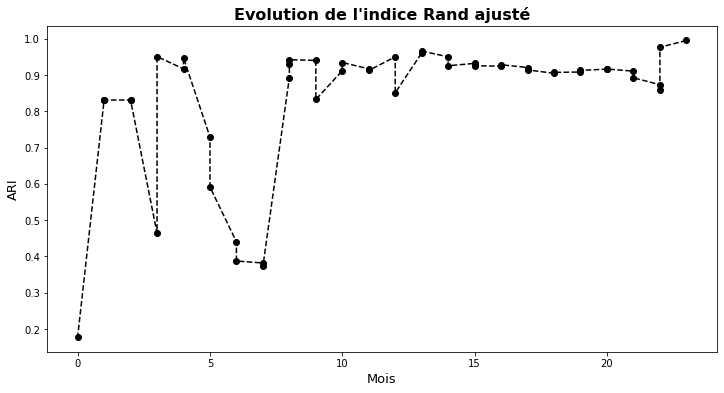

,Jours retranchés,ARI,days_update,month_update
0,7,0.995060,688,23.0
1,21,0.976340,674,22.0
2,35,0.859557,660,22.0
3,49,0.873206,646,22.0
4,63,0.892216,632,21.0
5,77,0.910530,618,21.0
6,91,0.916372,604,20.0
7,105,0.916049,590,20.0
8,119,0.912720,576,19.0
9,133,0.908181,562,19.0


In [18]:
# Affichage des différents scores
plt.figure(figsize=(12, 6))
calc_ARI(df_conso, M0, 7, 695, 14)

Le modèle devra être réentrainé tous les 7 mois. Nous pouvons donc établir un devis pour un contrat de maintenance qui intégrerait une mise à jour de la segmentation tous les 7 mois.